![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 12 - RNN Architectures </center>
### <center> Image Captioning - Preparations </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/12_RNN_Architectures/MainImageCaptioningPrep.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [7]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import numpy             as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn          as nn

### Load pre-trained ResNet152:
We keep all layers but the last one

In [9]:
oResNet152 = torchvision.models.resnet152(pretrained=True)
oModel     = nn.Sequential(*list(oResNet152.children())[:-1])
oModel.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


#### We use the model $f$ as a feature extractor:
$$\boldsymbol{I}\in\mathbb{R}^{3\times224\times224}$$
$$f\left(\boldsymbol{I}\right)\in\mathbb{R}^{2,048}$$

In [10]:
mX = torch.randn(1, 3, 244, 244)
oModel(mX).shape

torch.Size([1, 2048, 1, 1])

#### For each image in the dataset, extract the feature vector:

In [11]:
from torchvision import transforms
from PIL         import Image

#-- Image pre-processing:
vMean = torch.tensor([0.485, 0.456, 0.406])
vStd  = torch.tensor([0.229, 0.224, 0.225])

oPreprocess = transforms.Compose([
    transforms.Resize    (256),
    transforms.CenterCrop(224),
    transforms.ToTensor  (),
    transforms.Normalize (mean=vMean, std=vStd),
])

def GetProcessedImage(fileName):
    oImage = Image.open(fileName)
    mI     = oPreprocess(oImage)
    oImage.close()
    
    return mI

#### The (small) filker dataset:
https://www.kaggle.com/kunalgupta2616/flickr-8k-images-with-captions

In [12]:
dirPath         = r'C:\Users\oryai\Workarea\Data\Flicker8K\\'
captionFileName = 'captions.txt'

#-- Read the data:
with open(dirPath + captionFileName, 'r') as oFile:
    lLines = oFile.readlines()

lLines[:7]    

['image,caption\n',
 '1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .\n',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .\n',
 '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .\n',
 '1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting\n']

In [13]:
#-- Count the number of images in the dataset:
lImageFileName = [line.split(',')[0] for line in lLines[1:]] #-- first line is not an image
N = len(set(lImageFileName))
N

8091

#### Extract features
Apply the ResNet model and keep the final output.  
Speedup: Apply the model to batches (instead of a single image)

In [14]:
D          = 2048
mX         = np.full((N, D), np.nan)
lCaption   = [[]]   * N
lImageName = [None] * N

sName = set()
kk    = -1
with open(dirPath + captionFileName, 'r') as oFile:
    for ii, line in enumerate(oFile):
        if ii == 0:
            continue
            
        print(f'\r{N-kk:04}', end='')

        lSplit        = line.strip().split(',', maxsplit=1)
        imageFileName = lSplit[0]
        caption       = lSplit[1]

        #-- If new image:
        if imageFileName not in sName:
            sName.add(imageFileName)
            kk           += 1
            
            #-- Get the features:
            mXi = GetProcessedImage(dirPath + 'images\\' + imageFileName)[None,:,:,:]
            with torch.no_grad():
                vZi = oModel(mXi).squeeze()

            lCaption  [kk]    = [] #-- empty list
            lImageName[kk]    = imageFileName
            mX        [kk,:]  = vZi
            

        lCaption[kk] += [caption] #-- each image has 5 captions

0001

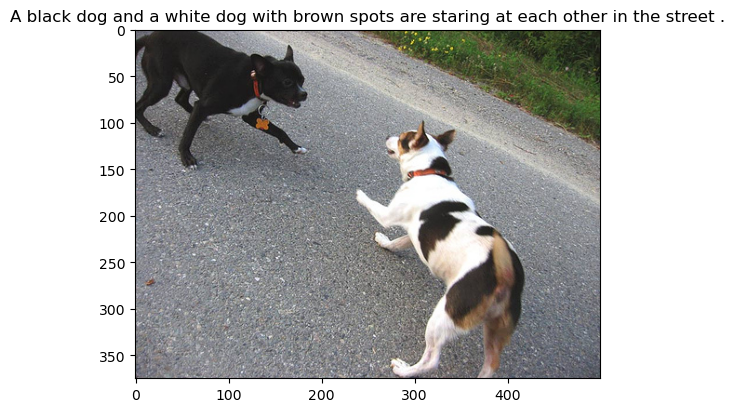

In [16]:
idx    = 1
oImage = Image.open(dirPath + 'images\\' + lImageName[idx])

plt.figure(figsize=(6, 6))
plt.imshow(oImage)
plt.title (lCaption[idx][2])
plt.show  ()

oImage.close()

#### Save the compact data:

In [17]:
import _pickle as pickle

np.savez('ImageCaptionData', mX=mX)
with open('ImageCaptionData.pkl', 'wb') as f:
    pickle.dump([lCaption, lImageName], f)

#### Load the data (if needed):

In [18]:
# import _pickle as pickle

# dData = np.load('ImageCaptionData.npz')
# mX    = dData['mX']

# with open('ImageCaptionData.pkl', 'rb') as f:
#     lCaption, lImageName = pickle.load(f)